<a href="https://colab.research.google.com/github/Narsi07/Landslide-susceptibility-prediction-using-AI-ML/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,f1_score, roc_auc_score, confusion_matrix)
import joblib

# Load dataset
data = pd.read_csv("/content/drive/MyDrive/Dataset/1844Points.csv")

# Check missing values
print(data.isnull().sum())

# Check data types
print(data.dtypes)

# Check normalization (e.g., mean ~0, std ~1?)
print(data.describe())

# Check categorical encoding
print(data.head())
print("\n")

print(data.duplicated().sum())
print("\n")

data.info()
#Handle Outliers (using IQR method)
# Target column name (modify if needed)
target_col = 'target'

# Prepare list of columns to include (exclude problematic ones)a
numerical_cols = []
for col in data.columns:
    if col == target_col:
        continue
    if data[col].dtype not in ['int64', 'float64']:
        continue
    if data[col].nunique() <= 10:  # likely binary or categorical
        continue
    numerical_cols.append(col)

# IQR-based capping only for valid numerical features
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

FID           0
X             0
Y             0
Aspect        0
DEM           0
DisToLinea    0
LineaDen      0
NDVI          0
Plan_Curva    0
Profile_Cu    0
Slope         0
Slope_Leng    0
STI           0
SPI           0
TPI           0
TWI           0
VRM           0
LULC_2015     0
habitat       0
GDP           0
DisFromRiv    0
DisFromRoa    0
target        0
dtype: int64
FID             int64
X             float64
Y             float64
Aspect        float64
DEM             int64
DisToLinea    float64
LineaDen      float64
NDVI          float64
Plan_Curva    float64
Profile_Cu    float64
Slope         float64
Slope_Leng    float64
STI           float64
SPI           float64
TPI           float64
TWI           float64
VRM           float64
LULC_2015       int64
habitat         int64
GDP             int64
DisFromRiv    float64
DisFromRoa    float64
target          int64
dtype: object
               FID            X            Y       Aspect          DEM  \
count  1844.000000  1844.

In [ ]:
# Create directories
os.makedirs('model_results', exist_ok=True)
os.makedirs('predictions', exist_ok=True)

data = data.drop(['FID', 'X', 'Y'], axis=1)

# Train-test split
X = data.drop('target', axis=1)
y = data['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,)


Starting hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:15:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:16:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best parameters found: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}

Training final model with best parameters...


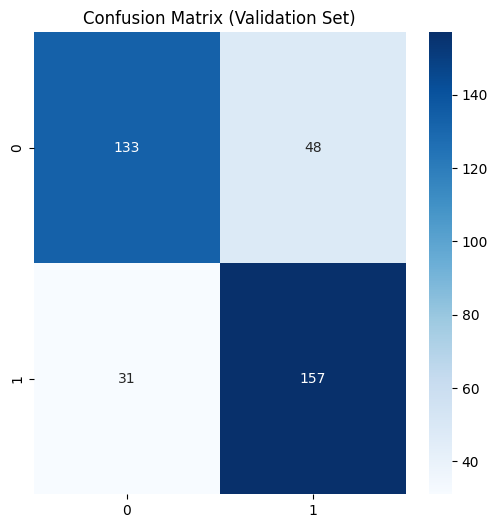

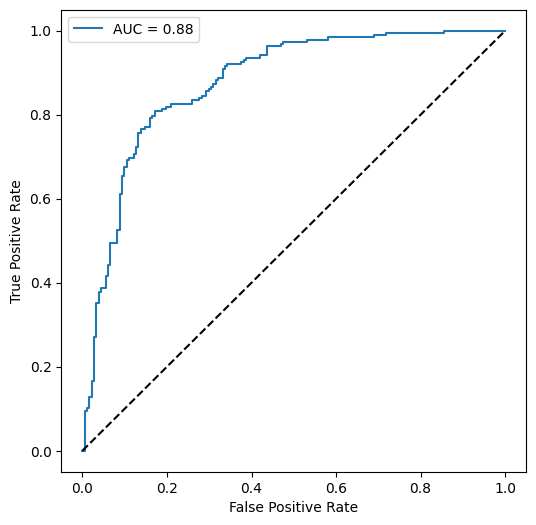

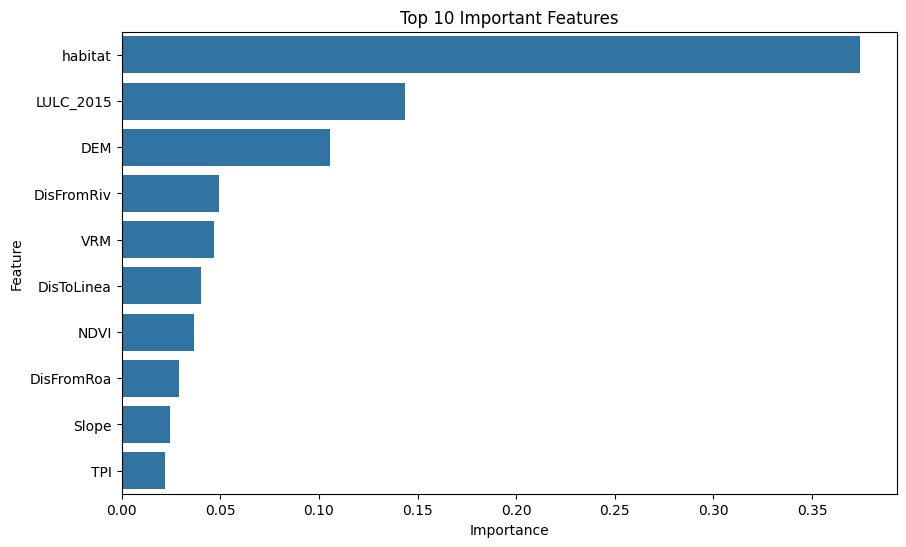

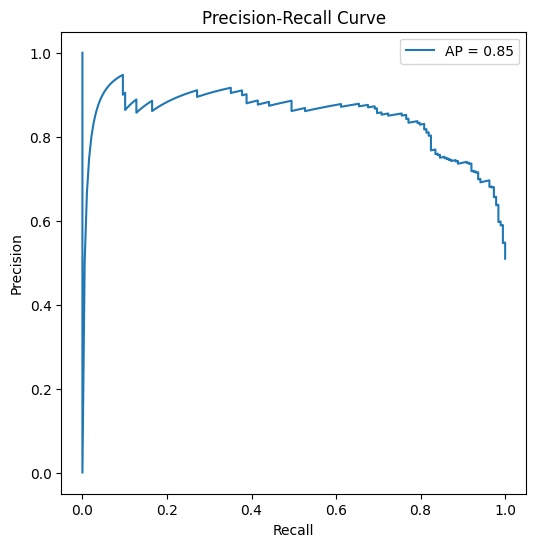




Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       181
           1       0.77      0.84      0.80       188

    accuracy                           0.79       369
   macro avg       0.79      0.78      0.78       369
weighted avg       0.79      0.79      0.79       369

Accuracy: 0.786
ROC AUC: 0.877

Top 10 Features:
   Feature  Importance
   habitat    0.374192
 LULC_2015    0.143869
       DEM    0.105379
DisFromRiv    0.049146
       VRM    0.046700
DisToLinea    0.040357
      NDVI    0.036599
DisFromRoa    0.029028
     Slope    0.024271
       TPI    0.021902


In [ ]:
#XGBOOST
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import xgboost as xgb
import joblib
import numpy as np
import os

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3]
}

# Initialize the base model
base_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Randomized search
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Perform the search on training data
print("Starting hyperparameter tuning...")
search.fit(X_train, y_train)

# Get the best parameters
best_params = search.best_params_
print(f"\nBest parameters found: {best_params}")

# Train the final model with best parameters on full training set
print("\nTraining final model with best parameters...")
final_model = xgb.XGBClassifier(**best_params, random_state=42, use_label_encoder=False, eval_metric='logloss')
final_model.fit(X_train, y_train)

# Evaluate on validation set
y_pred = final_model.predict(X_val)
y_proba = final_model.predict_proba(X_val)[:, 1]

# Save predictions and model
os.makedirs('predictions', exist_ok=True)
os.makedirs('model_results', exist_ok=True)

pd.DataFrame({'true': y_val, 'pred': y_pred, 'probability': y_proba})\
    .to_csv('predictions/xgb_predictions.csv', index=False)
joblib.dump(final_model, 'model_results/xgb_model.model')

# Confusion Matrix
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(y_val, y_pred),
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.show()
print("\n")
plt.close()

# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_val, y_proba):.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("\n")
plt.close()

# Feature Importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': final_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance.head(10))
plt.title('Top 10 Important Features')
plt.show()
print("\n")
plt.close()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_proba)
avg_precision = average_precision_score(y_val, y_proba)
plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()
print("\n")
plt.close()

# Print results
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {accuracy_score(y_val, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_val, y_proba):.3f}")
print("\nTop 10 Features:")
print(importance.head(10).to_string(index=False))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import joblib
import os
import numpy as np

# Load the dataset containing feature and target data
data01 = pd.read_csv("/content/drive/MyDrive/Dataset/1844Points.csv", encoding='gbk')

data01 = data.drop(['FID', 'X', 'Y'], axis=1)

# Define the path to save or load the RandomForest model
model_path = "/content/model_results/xgb_model.model"

# Set a random seed for reproducibility
seed = 4

# Specify filenames for importing and exporting additional datasets
filename_import = "/content/drive/MyDrive/Dataset/TheLocationOfTheStudyArea.csv"
filename_export = "/content/predictions/TheLocation_xgb_model.csv"

# Load the dataset for the study area's locations and features
data_all = pd.read_csv(filename_import)

# Prepare the dataset for predictions
X_all = data_all.drop(['FID', 'X', 'Y'], axis=1)

# Save the column names for later use
header = data01.columns.tolist()

# Split the dataset into two dataframes based on the target value
data_0 = data01.loc[data01['target'] == 0]  # Data where target = 0
data_1 = data01.loc[data01['target'] == 1]  # Data where target = 1

# Split data where target = 0 into 80% training and 20% validation sets
data_0_X = data_0.drop(columns=["target"], axis=1)
data_0_Y = data_0.target
train_0_X, valid_0_X, train_0_y, valid_0_y = train_test_split(data_0_X, data_0_Y, test_size=0.2, random_state=seed)
save_TrainDate_0 = pd.DataFrame(np.column_stack([train_0_X, train_0_y]), columns=header)
save_ValidDate_0 = pd.DataFrame(np.column_stack([valid_0_X, valid_0_y]), columns=header)

# Split data where target = 1 into 80% training and 20% validation sets
data_1_X = data_1.drop(columns=["target"], axis=1)
data_1_Y = data_1.target
train_1_X, valid_1_X, train_1_y, valid_1_y = train_test_split(data_1_X, data_1_Y, test_size=0.2, random_state=seed)
save_TrainDate_1 = pd.DataFrame(np.column_stack([train_1_X, train_1_y]), columns=header)
save_ValidDate_1 = pd.DataFrame(np.column_stack([valid_1_X, valid_1_y]), columns=header)

# Combine the training datasets and shuffle
train_date = pd.concat([save_TrainDate_0, save_TrainDate_1])
train_date = train_date.sample(frac=1, random_state=42)

# Combine the validation datasets and shuffle
valid_date = pd.concat([save_ValidDate_0, save_ValidDate_1])
valid_date = valid_date.sample(frac=1, random_state=42)

# Separate features and target from training and validation datasets
train_y = train_date.target
train_X = train_date.drop(columns=["target"], axis=1)
valid_y = valid_date.target
valid_X = valid_date.drop(columns=["target"], axis=1)

# Load the pre-trained RandomForest model
rf_model = joblib.load(model_path)

# Evaluate the model on validation set
y_pred = rf_model.predict(valid_X)
y_proba = rf_model.predict_proba(valid_X)[:, 1]

# Print evaluation metrics
print("******* Evaluation Metrics *******")
print(f"Accuracy: {accuracy_score(valid_y, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(valid_y, y_proba):.3f}")

# Process data for prediction on the study area dataset
header = X_all.columns.tolist()
latitude_and_longitude = data_all.drop(columns=header, axis=1)
X_all = X_all.reindex(columns=train_X.columns)  # Align columns with training data

# Perform predictions using the pre-trained model
Y_all = rf_model.predict_proba(X_all)[:, 1]  # Predict probabilities for positive class

# Convert predictions to DataFrame
Y_all = pd.DataFrame(Y_all, columns=['target'])

# Merge everything together: coordinates + all original features + predictions
merge_XY = pd.concat([
    latitude_and_longitude,  # X, Y and any other non-feature columns
    data_all[header],       # All feature columns used for prediction
    Y_all                   # Predicted probabilities
], axis=1)

# Select specific columns to keep in final output (all features + prediction)
final_columns = [
    'FID', 'X', 'Y',        # Identifier and coordinates
    'Aspect', 'DEM',        # Topographic features
    'DisToLinea', 'LineaDen', 'NDVI',  # Distance and vegetation
    'Plan_Curva', 'Profile_Cu', 'Slope',  # Curvature and slope
    'Slope_Leng', 'STI', 'SPI', 'TPI', 'TWI', 'VRM',  # Terrain indices
    'LULC_2015', 'habitat',   # Land use (note corrected from LULC_201)
    'GDP', 'DisFromRiv', 'DisFromRoa',  # Socio-economic
    'target'                # Prediction
]

# Ensure we only keep columns that actually exist in the data
final_columns = [col for col in final_columns if col in merge_XY.columns]

# Create final output with selected columnsy
final_output = merge_XY[final_columns]

# Save to CSV
final_output.to_csv(filename_export, index=False)

print("Merged predictions with all features successfully.")
print(final_output.columns.tolist())

******* Evaluation Metrics *******
Accuracy: 0.776
ROC AUC: 0.878
Merged predictions with all features successfully.
['FID', 'X', 'Y', 'Aspect', 'DEM', 'DisToLinea', 'LineaDen', 'NDVI', 'Plan_Curva', 'Profile_Cu', 'Slope', 'Slope_Leng', 'STI', 'SPI', 'TPI', 'TWI', 'VRM', 'LULC_2015', 'habitat', 'GDP', 'DisFromRiv', 'DisFromRoa', 'target']


In [ ]:
import pandas as pd
import joblib

# --- Load Data and Model ---
# Load your pre-generated predictions
predictions = pd.read_csv("/content/predictions/TheLocation_xgb_model.csv")  # Assuming columns: X, Y, target
predictions = predictions.rename(columns={'Habitat': 'habitat'})

# Load the trained model to get feature importance
model_path = "/content/model_results/xgb_model.model"
rf_model = joblib.load(model_path)

# Get feature names from the model (assuming it's a RandomForest)
features = rf_model.feature_names_in_

# --- Feature Importance ---
# Get top 10 features from the model's built-in feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

top_10_features = feature_importance.head(10)['Feature'].tolist()

# Calculate feature ranges from predictions
feature_ranges = {}
for feature in top_10_features:
    if feature in predictions.columns:
        feature_ranges[feature] = (predictions[feature].min(), predictions[feature].max())

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# --- Interactive Prediction Function ---
def predict_landslide():
    print("\n Landslide Risk Predictor ")
    print("Enter the following features (press Enter after each):")

    # Get user input only for top 10 features
    input_values = {}
    for feature in top_10_features:
        while True:
            try:
                range_info = f" (range: {feature_ranges.get(feature, ('?', '?'))[0]:.2f}-{feature_ranges.get(feature, ('?', '?'))[1]:.2f})" if feature in feature_ranges else ""
                val = float(input(f"{feature}{range_info}: "))
                input_values[feature] = val
                break
            except ValueError:
                print("Please enter a valid number")

    # Find the closest match in the pre-generated predictions
    closest_match = None
    min_distance = float('inf')

    for _, row in predictions.iterrows():
        # Calculate a simple distance metric (could be improved)
        distance = sum(
            (input_values[feature] - row[feature])**2
            for feature in top_10_features
            if feature in row
        )

        if distance < min_distance:
            min_distance = distance
            closest_match = row

    # Show results
    if closest_match is not None:
        risk_level = "HIGH RISK" if closest_match['target'] >= 0.5 else "LOW RISK"
        print(f"\nPrediction: {risk_level}")
        print(f"Probability: {closest_match['target']:.1%}")
        print(f"Closest matching location: X={closest_match['X']}, Y={closest_match['Y']}")

        # Show top 3 features that contributed to this prediction
        print("\nMain contributing factors in this area:")
        top3 = feature_importance.head(3)
        for i, row in top3.iterrows():
            value = closest_match.get(row['Feature'], "unknown")
            print(f"- {row['Feature']} (value: {value}, importance: {row['Importance']:.3f})")
    else:
        print("\nNo matching location found in the pre-generated predictions")

# --- Run Interactive Prediction ---
while True:
    predict_landslide()
    if input("\nPredict another location? (y/n): ").lower() != 'y':
        break


Top 10 Most Important Features:
       Feature  Importance
15     habitat    0.374192
14   LULC_2015    0.143869
1          DEM    0.105379
17  DisFromRiv    0.049146
13         VRM    0.046700
2   DisToLinea    0.040357
4         NDVI    0.036599
18  DisFromRoa    0.029028
7        Slope    0.024271
11         TPI    0.021902

 Landslide Risk Predictor 
Enter the following features (press Enter after each):
habitat (range: 100.00-1400.00): 1000
LULC_2015 (range: 0.00-8.00): 4
DEM (range: 242.00-2588.00): 1030
DisFromRiv (range: 0.00-10698.60): 7980
VRM (range: 0.00-0.18): 0.11
DisToLinea (range: 0.00-3483.23): 2456
NDVI (range: -0.09-0.51): 0.21
DisFromRoa (range: -9999.00-20340.30): 10890
Slope (range: 0.00-78.07): 56
TPI (range: -87.95-89.11): 34

Prediction: LOW RISK
Probability: 10.6%
Closest matching location: X=109.953205, Y=31.979302

Main contributing factors in this area:
- habitat (value: 100.0, importance: 0.374)
- LULC_2015 (value: 2.0, importance: 0.144)
- DEM (value: 145

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import joblib
import gradio as gr

# --- Load Data and Model ---
try:
    predictions = pd.read_csv("/content/predictions/TheLocation_xgb_model.csv")
    predictions = predictions.rename(columns={'Habitat': 'habitat'})  # Rename here
    model_path = "/content/model_results/xgb_model.model"
    rf_model = joblib.load(model_path)

    # Get feature names and importance
    features = rf_model.feature_names_in_
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    top_10_features = feature_importance.head(10)['Feature'].tolist()

    # Calculate input ranges
    feature_ranges = {feature: (predictions[feature].min(), predictions[feature].max())
                     for feature in top_10_features if feature in predictions.columns}

except Exception as e:
    print(f"Initialization error: {str(e)}")
    # Create dummy data if loading fails for demo purposes
    top_10_features = ['feature1', 'feature2', 'feature3']
    feature_ranges = {f: (0, 100) for f in top_10_features}

def predict_landslide(*input_values):
    try:
        # Verify data loaded correctly
        if 'predictions' not in globals():
            return ["Error"] * 7 + ["Data not loaded properly"]

        # Convert inputs to dictionary
        input_dict = dict(zip(top_10_features, [float(v) for v in input_values]))

        # Find closest match
        predictions['distance'] = predictions[top_10_features].sub(pd.Series(input_dict)).pow(2).sum(axis=1)
        closest_match = predictions.loc[predictions['distance'].idxmin()]

        # Prepare results
        prob = float(closest_match['target'])
        will_occur = "Yes" if prob >= 0.5 else "No"
        risk_level = "High" if prob >= 0.7 else "Medium" if prob >= 0.5 else "Low"

        return [
            will_occur,
            risk_level,
            f"{prob:.1%}",
            f"{float(closest_match['X']):.4f}",
            f"{float(closest_match['Y']):.4f}",
            f"{feature_importance.iloc[0]['Feature']}: {float(closest_match[feature_importance.iloc[0]['Feature']]):.2f}",
            f"{feature_importance.iloc[1]['Feature']}: {float(closest_match[feature_importance.iloc[1]['Feature']]):.2f}",
            f"{feature_importance.iloc[2]['Feature']}: {float(closest_match[feature_importance.iloc[2]['Feature']]):.2f}"
        ]

    except Exception as e:
        error_msg = f"Prediction error: {str(e)}"
        return ["Error"] * 7 + [error_msg]

# Create input components
inputs = [
    gr.Slider(
        label=f"{feature} (range: {feature_ranges.get(feature, (0, 100))[0]:.2f}-{feature_ranges.get(feature, (0, 100))[1]:.2f})",
        minimum=float(feature_ranges.get(feature, (0, 100))[0]),
        maximum=float(feature_ranges.get(feature, (0, 100))[1])
    ) for feature in top_10_features
]

# Create output components
outputs = [
    gr.Textbox(label="Will landslide occur?"),
    gr.Textbox(label="Risk Level"),
    gr.Textbox(label="Probability"),
    gr.Textbox(label="Nearest Location (X)"),
    gr.Textbox(label="Nearest Location (Y)"),
    gr.Textbox(label="Most Important Factor"),
    gr.Textbox(label="Second Important Factor"),
    gr.Textbox(label="Third Important Factor"),
    gr.Textbox(label="Debug Info", visible=False)  # Hidden debug output
]

# Create interface
demo = gr.Interface(
    fn=predict_landslide,
    inputs=inputs,
    outputs=outputs[:-1],  # Exclude debug output
    title="Landslide Prediction System",
    description="Enter the geological feature values to predict landslide risk:",
    allow_flagging="never",
    theme="default"
)

if __name__ == "__main__":
    demo.launch()

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b4ab6e018c27cd439e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
